# Deep learning Morpion Solitaire

In Google Colab, needs to upgrade `fastai` to newest version:

In [1]:
# !pip install --upgrade fastai

Load `fastai` library:

In [2]:
from fastai.vision.all import *
from fastai.callback.hook import *

/home/marc/anaconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
from tqdm.notebook import trange
from pathlib import Path
import numpy as np
import pandas as pd
import torch
from PIL import Image

## Load data

Import data when running in Google Colab:

In [4]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [5]:
# !ls -l 'gdrive/MyDrive/Colab Notebooks/'

In [6]:
# !tar -xf 'gdrive/MyDrive/Colab Notebooks/data.tar.gz'
# !ls -l

Import the data:

In [7]:
paths = ['data/run_0_cross', 'data/run_0_pipe', 'data/run_0_random']
data_grids = []
data_n_avg = []
data_n_std = []
data_n_max = []
for path in paths:
    data = np.load(Path(path)/'grids.npy')
    data_grids += [data[i] for i in range(len(data))]
    data = np.load(Path(path)/'n.npy')
    data_n_avg += [data[i][0] for i in range(len(data))]
    data_n_std += [data[i][1] for i in range(len(data))]
    data_n_max += [data[i][2] for i in range(len(data))]
len(data_grids), len(data_n_avg), len(data_n_std), len(data_n_max)

(30000, 30000, 30000, 30000)

Create a Pandas dataframe:

In [8]:
df = pd.DataFrame(zip(data_grids, data_n_avg, data_n_std, data_n_max),
                  columns = ['grid', 'n_avg', 'n_std', 'n_max']) 

Shuffle the data:

In [9]:
df = df.sample(frac=1).reset_index(drop=True)

### Examine the data

In [10]:
df['n_max'].describe()

count    30000.000000
mean        38.516633
std         24.206661
min          0.000000
25%         14.000000
50%         44.000000
75%         60.000000
max         89.000000
Name: n_max, dtype: float64

Visualization function for grid data:

In [11]:
def image(grid):
    w = 3 * grid.shape[1] - 2
    h = 3 * grid.shape[2] - 2
    im = np.empty((w, h), dtype=bool)
    im[0::3,0::3] = grid[0,:,:]
    im[1::3,0::3] = grid[1,:-1,:]
    im[2::3,0::3] = grid[1,:-1,:]
    im[0::3,1::3] = grid[2,:,:-1]
    im[0::3,2::3] = grid[2,:,:-1]
    im[1::3,1::3] = grid[3,:-1,:-1]
    im[2::3,2::3] = grid[3,:-1,:-1]
    im[1::3,2::3] = grid[4,1:,:-1]
    im[2::3,1::3] = grid[4,1:,:-1]
    return im

In [12]:
def visualize(grid):
    return Image.fromarray(~image(grid))

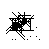

In [13]:
visualize(df['grid'].iloc[0])

In [14]:
df['n_max'].iloc[0]

37.0

Maximum values of `n`:

In [15]:
df['n_max'].loc[df['n_max'].idxmax()]

89.0

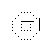

In [16]:
visualize(df['grid'].loc[df['n_max'].idxmax()])

In [17]:
df['n_max'].loc[df['n_max'].idxmin()]

0.0

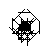

In [18]:
visualize(df['grid'].loc[df['n_max'].idxmin()])

# DataLoaders

In [19]:
GRID_SIZE = 24

The `x` value is a grid of size `GRID_SIZE x GRID_SIZE`, with the actual grid loaded from the dataframe inserted at a random position. In addition, we add a random mirror flip and a random rotation (not implemented yet!).

In [20]:
def get_x(data):
    im = image(data['grid'])
    # rotate the image at random
    im = np.rot90(im, np.random.randint(4))
    # flip the image at random
    if np.random.randint(2) == 1:
        im = np.fliplr(im)
    w = (im.shape[0] + 2) // 3
    h = (im.shape[1] + 2) // 3
    if w < GRID_SIZE:
        i = np.random.randint(GRID_SIZE - w)
    else:
        i = 0
    if h < GRID_SIZE:
        j = np.random.randint(GRID_SIZE - h)
    else:
        j = 0
    grid = torch.zeros((5, GRID_SIZE, GRID_SIZE))
    grid[0,i:i+w,j:j+h] = torch.tensor(im[0::3,0::3].astype(float))
    grid[1,i:i+w-1,j:j+h] = torch.tensor(im[1::3,0::3].astype(float))
    grid[2,i:i+w,j:j+h-1] = torch.tensor(im[0::3,1::3].astype(float))
    grid[3,i:i+w-1,j:j+h-1] = torch.tensor(im[1::3,1::3].astype(float))
    grid[4,i+1:i+w,j:j+h-1] = torch.tensor(im[1::3,2::3].astype(float))
    return grid

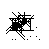

In [22]:
visualize(df['grid'].iloc[0])

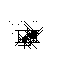

In [24]:
visualize(get_x(df.iloc[0]))

For `y`, we want a number distributed around 0, based on `n` that is a non-negative integer (positive or zero), potentially unbounded. We define
$$
y(n) = \frac{\log(n+1)}{\log(n_* + 1)} - 1,
$$
so that $y(0) = -1$, $y(n_*) = 0$, $y(n_*(n_* + 2)) = 1$.

If we take $n_*$ small, say for instance $n_* = 1$, then the model will discriminate best among low values of $n$; if on the contrary we take $n_*$ big, then the model will discriminate best among large values of $n$.

We will take $n_* = 10$, so that $\log(n_* + 1) \approx 2.4$.

In [29]:
LOGNSTAR = 2.4

In [30]:
def get_y(data):
    n = torch.tensor([data['n_max']]).float()
    return torch.log(n + 1)/LOGNSTAR - 1

We also define the inverse function, that takes `y` to `n`.
$$
n(y) = \exp\left[ \log(n_* + 1) (y + 1) \right] - 1
$$
This will be useful for inference at the end of the day:

In [31]:
def n_of_y(y):
    return torch.exp(LOGNSTAR* (y + 1)) - 1

DataBlock and DataLoaders:

In [32]:
dblock = DataBlock(get_x = get_x, get_y = get_y)

In [33]:
dls = dblock.dataloaders(df, bs = 250)

Check one batch:

In [36]:
x_batch, y_batch = to_cpu(dls.one_batch())
x_batch.shape, y_batch.shape

(torch.Size([250, 5, 24, 24]), torch.Size([250, 1]))

In [37]:
y_batch[0:10]

tensor([[ 0.7702],
        [ 0.5672],
        [-0.0845],
        [ 0.7060],
        [ 0.4030],
        [ 0.4308],
        [ 0.5473],
        [ 0.4030],
        [-0.3294],
        [ 0.5574]])

## Accuracy metrics

For the **metrics**, we compute `n` from the model predictions, round up the result to the nearest integer and compare with the target:

In [38]:
def n_accuracy(inputs, targets):
    n_pred = torch.round(n_of_y(inputs))
    n_targ = torch.round(n_of_y(targets))
    return torch.where(n_pred == n_targ, 1.0, 0.0).mean()

Alternatively, we can ask the result to be within 20% accuracy of the actual number:

In [44]:
def n_ten(inputs, targets):
    n_pred = torch.round(n_of_y(inputs))
    n_targ = torch.round(n_of_y(targets))
    return torch.where(torch.abs(n_pred - n_targ) < 0.2 * n_targ, 1.0, 0.0).mean()

In [45]:
def n_twenty(inputs, targets):
    n_pred = torch.round(n_of_y(inputs))
    n_targ = torch.round(n_of_y(targets))
    return torch.where(torch.abs(n_pred - n_targ) < 0.2 * n_targ, 1.0, 0.0).mean()

## Convolutional neural network

Define the network architecture:

Small network for testing:

In [ ]:
# net = nn.Sequential(
#     # stem: use 3 layers with 3x3 kernel, and quite a few parameters
#     nn.Conv2d(5, 32, stride = 1, kernel_size = 3, padding = 0),
#     nn.ReLU(),
#     nn.Conv2d(32, 128, stride = 1, kernel_size = 3, padding = 0),
#     nn.ReLU(),
#     nn.Conv2d(128, 512, stride = 1, kernel_size = 3, padding = 0),
#     nn.ReLU(),
#     # flattening
#     nn.AdaptiveMaxPool2d(1),
#     Flatten(),
#     # another couple of linear layers to perform basic operations
#     nn.Linear(512, 256),
#     nn.ReLU(),
#     nn.Linear(256, 128),
#     nn.ReLU(),
#     nn.Linear(128, 64),
#     nn.ReLU(),
#     nn.Linear(64, 1)
# )

In [40]:
net = nn.Sequential(
    ConvLayer(5, 32, padding = 0),
    ConvLayer(32, 128, padding = 0),
    ConvLayer(128, 512, padding = 0),
    nn.AdaptiveMaxPool2d(1),
    Flatten(),
    LinBnDrop(512, 512, act=nn.ReLU()),
    LinBnDrop(512, 512, act=nn.ReLU()),
    LinBnDrop(512, 1)
)

Bigger network:

In [ ]:
net = nn.Sequential(
    ConvLayer(5, 32, padding = 0),
    ConvLayer(32, 128, padding = 0),
    ConvLayer(128, 512, padding = 0),
    ConvLayer(512, 2048, padding = 0),
    ConvLayer(2048, 2048, padding = 0),
    ConvLayer(2048, 2048, padding = 0),
    ConvLayer(2048, 2048, padding = 0),
    nn.AdaptiveMaxPool2d(1),
    Flatten(),
    LinBnDrop(2048, 2048, act=nn.ReLU()),
    LinBnDrop(2048, 2048, act=nn.ReLU()),
    LinBnDrop(2048, 1)
)

### Testing

In [46]:
x_batch_pred = net(x_batch)
x_batch_pred.shape

torch.Size([250, 1])

In [47]:
n_accuracy(x_batch_pred, y_batch), n_ten(x_batch_pred, y_batch), n_twenty(x_batch_pred, y_batch)

(tensor(0.0240), tensor(0.0480), tensor(0.0480))

## Training

In [49]:
learn = Learner(dls, net, loss_func = nn.MSELoss(),
                metrics = [n_accuracy, n_ten, n_twenty],
                cbs = ActivationStats(with_hist = True))

In [ ]:
# learn.model.cuda()

In [ ]:
# learn.summary()

In [ ]:
# learn.lr_find()

In [ ]:
learn.fit_one_cycle(20, lr_max = 5.0e-3) # 5.0e-3 for smaller model

In [ ]:
learn.activation_stats.plot_layer_stats(0)

In [ ]:
learn.activation_stats.plot_layer_stats(-2)

In [ ]:
learn.activation_stats.color_dim(0)

In [ ]:
learn.activation_stats.color_dim(-2)

In [ ]:
# learn.export(fname = 'models/model_0.pkl')

In [ ]:
# torch.save(net, 'models/model_0.pkl')

## Inference

**TO DO**: implement a function that infers `n` using the model, and then compare the predictions with the actual value of `n`, as well as with the 1- and 2-sigma confidence intervals.

In [ ]:
x = torch.tensor(data_grids[0:1000]).float()
x.shape

In [ ]:
n_pred = n_of_y(net(x).data).squeeze()
n_val = torch.tensor(data_n_max[0:1000])
n_std = torch.tensor(data_n_std[0:1000])

In [ ]:
n_pred[0:10], n_val[0:10]

In [ ]:
def accuracy_sigma(sigma):
    return torch.where(torch.abs(n_pred - n_val) < 0.5 + sigma * n_std, 1.0, 0.0).mean()

In [ ]:
accuracy_sigma(0), accuracy_sigma(1), accuracy_sigma(2), accuracy_sigma(3)

In [ ]:
x_valid, y_valid = dls.valid.one_batch()

In [ ]:
visualize(x_valid[0])

In [ ]:
n_valid = n_of_y(y_valid)

In [ ]:
y_valid[0], n_of_y(y_valid[0])

In [ ]:
x_preds = net(x_valid).data

In [ ]:
x_preds.squeeze().mean()

In [ ]:
x_preds.squeeze().std()

In [ ]:
n_preds = n_of_y(x_preds)

In [ ]:
torch.stack([n_preds.squeeze(), n_valid.squeeze()]).T

In [ ]:
n_preds.squeeze().mean(), n_preds.squeeze().std()